# Model Creation

Now that we have completed the analysis we need to move to another section of the task-creating a model to perform predictions.

## <a id="index">Table of Contents:</a>
* [Data Collection](#collection)
* [Data Preprocesing](#preprocesing)
* [Model Development](#development)
    * [Model Analysis](#model-analysis)
        * [Logistic Regression Model Analysis](#log-analysis)
            * [Hyper Parameter Tuning](#lreg-tuning)
            * [Model Evaluation](#lreg-evaluation)
        * [SVC Model Analysis](#svc-analysis)
            * [Hyper Parameter Tuning](#svc-tuning)
            * [Model Evaluation](#svc-evaluation)
        * [Ensemble Model: Random Forest Model Analysis](#rfc-analysis)
            * [Hyper Parameter Tuning](#rfc-tuning)
            * [Model Evaluation](#rfc-evaluation)
    * [Feature Importance](#feature-importance)
    * [Optimizing for the Target Class](#target-optimization)
    * [Championing a Model](#champion-model)
* [Summary](#summary)

## <a id="collection">Data Collection</a> <font size='2'>[Table of contents🔝](#index)<font size>

In this step we will load in the data and define our functions.

In [1]:
# %pip install optuna
# %pip install -r ../requirements.txt

In [ ]:
import os
import pandas as pd
import numpy as np
import optuna
import matplotlib.pyplot as plt

from sklearn.compose import make_column_transformer

from sklearn.model_selection import cross_validate, train_test_split
from sklearn.metrics import f1_score, recall_score, make_scorer, balanced_accuracy_score

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier 

In [3]:
def get_dataTypes_and_missingValues(df):
    info = pd.DataFrame()
    info['data_types'] =  df.dtypes
    info['unique_values'] = df.nunique()
    info['missing_values'] = df.isna().sum()
    return info

In [4]:
def read_recipe_data(path):
    '''Read in the data from the path and return a train, validation and test set'''
    
    df = pd.read_csv(path)

    df['high_traffic'].fillna("Low", inplace=True)
    df.drop('recipe', axis=1, inplace=True)
    df.drop_duplicates(inplace=True)

    y = df['high_traffic']
    X = df.drop('high_traffic', axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42, shuffle=True)

    return X_train, y_train, X_val, y_val, X_test, y_test

In [5]:
def encode_categorical_features(categorical_features):
    '''
    Encodes the categorical features using OneHotEncoder
    '''

    ct = make_column_transformer(
        (OneHotEncoder(handle_unknown='ignore'), categorical_features),
        remainder='passthrough'
    )
    
    return ct

def encode_label(y):
    '''
    Encodes the labels/targets using LabelEncoder
    '''

    enc = LabelEncoder()
    y_enc = enc.fit_transform(y)
    
    return y_enc

In [6]:
def train_model_with_cross_val(X_train, y_train, model_algorithm, **model_kwargs):
    '''
    Trains a model with cross-validation and returns evaluation scores
    '''
    
    if 'random_state' in model_algorithm().get_params():
        model_kwargs['random_state'] = 124

    model = model_algorithm(**model_kwargs)

    scoring = {
        'accuracy': 'accuracy',
        'f1': 'f1',
        'recall':'recall',
        'balanced_accuracy': make_scorer(balanced_accuracy_score)
    }
    categorical_cols = X_train.select_dtypes(exclude=np.number).columns.to_list()
    ct = encode_categorical_features(categorical_cols)

    pipeline = make_pipeline(ct, StandardScaler(), model)
    y_train_encoded  = encode_label(y_train)

    scores = cross_validate(pipeline, X_train, y_train_encoded, scoring=scoring)
    
    return pd.DataFrame(scores)

In [7]:
def train_model(X_train, y_train, X_val, y_val, model_algorithm, **model_kwargs):
    '''
    Trains a model without cross-validation and returns evaluation scores
    '''
    
    if 'random_state' in model_algorithm().get_params():
        model_kwargs['random_state'] = 124

    model = model_algorithm(**model_kwargs)

    categorical_cols = X_train.select_dtypes(exclude=np.number).columns.to_list()
    ct = encode_categorical_features(categorical_cols)

    pipeline = make_pipeline(ct, StandardScaler(), model)
    y_train_encoded  = encode_label(y_train)
    y_val_encoded  = encode_label(y_val)

    pipeline.fit(X_train, y_train_encoded)
    y_pred = pipeline.predict(X_val)
    recall = recall_score(y_val_encoded, y_pred)
    f1 = f1_score(y_val_encoded, y_pred)
    scores = {'recall': recall, 'f1_score': f1}
    
    return pd.DataFrame(scores, index=[0])

## <a id="preprocesing">Data Preprocesing</a> <font size='2'>[Table of contents🔝](#index)<font size>

In [8]:
data_path = os.path.join("..","data", "recipe_site_traffic.csv")
X_train, y_train, X_val, y_val, X_test, y_test = read_recipe_data(data_path)

In [9]:
train_df = pd.concat([X_train, y_train], axis=1)
missing_indices = train_df[train_df['calories'].isnull()].index
train_df.drop(missing_indices, inplace=True)
get_dataTypes_and_missingValues(train_df)

,data_types,unique_values,missing_values
calories,float64,612,0
carbohydrate,float64,579,0
sugar,float64,495,0
protein,float64,551,0
category,object,11,0
servings,object,5,0
high_traffic,object,2,0


In [10]:
train_df['category'].replace('Chicken Breast', 'Chicken', inplace=True)
non_numeric_cols = train_df.drop('high_traffic', axis='columns').select_dtypes(exclude=np.number).columns.values
for col in non_numeric_cols:
    try:
        train_df[col].astype(int)
    except Exception:
        print(f"The column: {col} contains non-numeric characters")

mask = train_df['servings'].astype(str).str.contains(r'\D', regex=True)
non_numeric_values = train_df[mask]

print("Non-numeric values in servings")
non_numeric_values

The column: category contains non-numeric characters
The column: servings contains non-numeric characters
Non-numeric values in servings


,calories,carbohydrate,sugar,protein,category,servings,high_traffic
735,513.75,65.87,18.63,18.39,Lunch/Snacks,4 as a snack,Low


In [11]:
train_df.loc[mask, 'servings'] = 4
train_df['servings'] = train_df['servings'].astype(int)

# split
y_train = train_df['high_traffic']
X_train = train_df.drop('high_traffic', axis=1)

## <a id="development">Model Development</a> <font size='2'>[Table of contents🔝](#index)<font size>

Several models are appropriate for this analysis including:
* Logistic Regression
* Ensemble: build up from the base model by using wisdom of the crowd
* Support Vectors: great for small data that could be linearly seperable

Models based on the different families listed above will be used on this problem. 

Before than we need to define KPIs that we would use to evaluate my model.
The problem statement prioritizes predicting high traffic so we will use recall as my metric and have f1-score as a secondary metric.
<BR/>The KPI is `Recipe Popularity Prediction Indicator(RPPI)` statistically referred to as recall.

In [12]:
model = LogisticRegression
scores = train_model_with_cross_val(X_train, y_train, model)

print(f"{model.__name__} Scores:")
scores

LogisticRegression Scores:


,fit_time,score_time,test_accuracy,test_f1,test_recall,test_balanced_accuracy
0,0.025734,0.004999,0.772358,0.735849,0.780000,0.773562
1,0.006082,0.006341,0.780488,0.721649,0.700000,0.767808
2,0.004007,0.007950,0.813008,0.762887,0.740000,0.801507
3,0.006713,0.006007,0.731707,0.659794,0.640000,0.717260
4,0.005151,0.004107,0.754098,0.680851,0.653061,0.737490


**SVC's**

In [ ]:
model = LinearSVC
scores = train_model_with_cross_val(X_train, y_train, model)

print(f"{model.__name__} Scores:")
scores

In [14]:
model = SVC
scores = train_model_with_cross_val(X_train, y_train, model)

print(f"{model.__name__} Scores:")
scores

SVC Scores:


,fit_time,score_time,test_accuracy,test_f1,test_recall,test_balanced_accuracy
0,0.011527,0.007522,0.780488,0.742857,0.780000,0.780411
1,0.010525,0.006510,0.772358,0.708333,0.680000,0.757808
2,0.007927,0.010850,0.813008,0.762887,0.740000,0.801507
3,0.009521,0.007523,0.723577,0.645833,0.620000,0.707260
4,0.008613,0.007277,0.737705,0.652174,0.612245,0.717081


**Ensemble Models**

In [15]:
model = RandomForestClassifier
np.random.seed(142)
scores = train_model_with_cross_val(X_train, y_train, model)

print(f"{model.__name__} Scores:")
scores

RandomForestClassifier Scores:


,fit_time,score_time,test_accuracy,test_f1,test_recall,test_balanced_accuracy
0,0.201559,0.010232,0.739837,0.698113,0.740000,0.739863
1,0.164984,0.008436,0.715447,0.646465,0.640000,0.703562
2,0.149786,0.015100,0.739837,0.659574,0.620000,0.720959
3,0.184770,0.010940,0.731707,0.629213,0.560000,0.704658
4,0.164324,0.005231,0.680328,0.541176,0.469388,0.645653


In [16]:
model = XGBClassifier
scores = train_model_with_cross_val(X_train, y_train, model)

print(f"{model.__name__} Scores:")
scores

XGBClassifier Scores:


,fit_time,score_time,test_accuracy,test_f1,test_recall,test_balanced_accuracy
0,0.086456,0.007334,0.699187,0.660550,0.720000,0.702466
1,0.073972,0.006211,0.691057,0.612245,0.600000,0.676712
2,0.080976,0.012537,0.666667,0.623853,0.680000,0.668767
3,0.059047,0.011268,0.626016,0.488889,0.440000,0.596712
4,0.056611,0.009513,0.663934,0.528736,0.469388,0.631954


Next, we evaluate the performance of the different models.

After evaluating 3 model families, Logistic Regression as a base model, Support Vector Machines and Ensembles we perform hyper parameter tuning on the champion models from each family:
* Logistic Regression
* SVC
* Random Forest Classifier

For the hyper parameter tuning let's opt for optuna for it's flexibility and scalability.
<br/>Let us start by preparing the validation data.

In [17]:
val_df = pd.concat([X_val, y_val], axis=1)
missing_indices = val_df[val_df['calories'].isnull()].index
val_df.drop(missing_indices, inplace=True)
get_dataTypes_and_missingValues(val_df)

,data_types,unique_values,missing_values
calories,float64,105,0
carbohydrate,float64,104,0
sugar,float64,101,0
protein,float64,103,0
category,object,11,0
servings,object,4,0
high_traffic,object,2,0


In [18]:
val_df['category'].replace('Chicken Breast', 'Chicken', inplace=True)
non_numeric_cols = val_df.drop('high_traffic', axis='columns').select_dtypes(exclude=np.number).columns.values
for col in non_numeric_cols:
    try:
        val_df[col] = val_df[col].astype(int)
    except Exception:
        print(f"The column: {col} contains non-numeric characters")

mask = val_df['servings'].astype(str).str.contains(r'\D', regex=True)
non_numeric_values = val_df[mask]

print("Non-numeric values in servings")
non_numeric_values

The column: category contains non-numeric characters
Non-numeric values in servings


,calories,carbohydrate,sugar,protein,category,servings,high_traffic


In [19]:
get_dataTypes_and_missingValues(val_df)

,data_types,unique_values,missing_values
calories,float64,105,0
carbohydrate,float64,104,0
sugar,float64,101,0
protein,float64,103,0
category,object,10,0
servings,int32,4,0
high_traffic,object,2,0


The category was reduced to 10 from 11 combining `Chicken` and `Chicken Breast` into 1 category.

In [20]:
# split
y_val = val_df['high_traffic']
X_val = val_df.drop('high_traffic', axis=1)

In [21]:
import warnings
warnings.filterwarnings("ignore")

### <a id="model-analysis">Model Analysis</a> <font size='2'>[Table of contents🔝](#index)<font size>

In [22]:
from sklearn.metrics import confusion_matrix, roc_curve, auc

In [23]:
def get_trained_model(X_train, y_train, model_algorithm, **model_kwargs):
    
    if 'random_state' in model_algorithm().get_params():
        model_kwargs['random_state'] = 124

    model = model_algorithm(**model_kwargs)

    categorical_cols = X_train.select_dtypes(exclude=np.number).columns.to_list()
    ct = encode_categorical_features(categorical_cols)

    pipeline = make_pipeline(ct, StandardScaler(), model)
    y_train_encoded  = encode_label(y_train)

    pipeline.fit(X_train, y_train_encoded)
    
    return pipeline

def plot_conf_matrix(X_train, y_train, X_val, y_val, model_algorithm, **model_kwargs):
    
    model = get_trained_model(X_train, y_train, model_algorithm, **model_kwargs)
    y_pred = model.predict(X_val)
    y_val_encoded  = encode_label(y_val)
    
    
    conf_matrix = confusion_matrix(y_val_encoded, y_pred)
    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    plt.xticks([0, 1], ['Predicted Negative', 'Predicted Positive'])
    plt.yticks([0, 1], ['Actual Negative', 'Actual Positive'])
    plt.xlabel('True labels')
    plt.ylabel('Predicted labels')
    plt.show()

def plot_roc_curve(X_train, y_train, X_val, y_val, model_algorithm, **model_kwargs):
    
    model = get_trained_model(X_train, y_train, model_algorithm, **model_kwargs)
    y_pred = model.predict(X_val)
    y_val_encoded  = encode_label(y_val)
    
    fpr, tpr, _ = roc_curve(y_val_encoded, y_pred, pos_label=1) 
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

#### <a id="log-analysis">Logistic Regression Model Analysis</a> <font size='2'>[Table of contents🔝](#index)<font size>

##### <a id="lreg-tuning">Hyper Parameter Tuning</a> <font size='2'>[Table of contents🔝](#index)<font size>

In [24]:
def objective(trial):
    # Define hyperparameters to optimize
    C = trial.suggest_float('C', 0.001, 1e5, log=True)
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
    tol = trial.suggest_float('tol', 1e-5, 1e-3, log=True)  
    l1_ratio = trial.suggest_float('l1_ratio', 0, 1)  
    
    # Create and train the Logistic Regression model with these hyperparameters
    model = LogisticRegression
    model_kwargs = {'C': C, 'penalty': penalty, 'tol': tol, 'l1_ratio': l1_ratio, 'solver':'liblinear'}
    scores = train_model(X_train, y_train, X_val, y_val, model, **model_kwargs)
    combined_objective = scores['recall']
    
    # Return the combined objective (to be maximized)
    return combined_objective


In [25]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2024-01-23 21:04:20,724] A new study created in memory with name: no-name-514cf6d3-c8f5-40f5-be98-7e0d14b788a0
[I 2024-01-23 21:04:20,742] Trial 0 finished with value: 0.7346938775510204 and parameters: {'C': 649.2186136535354, 'penalty': 'l2', 'tol': 0.0009394694993945822, 'l1_ratio': 0.000901266590224048}. Best is trial 0 with value: 0.7346938775510204.
[I 2024-01-23 21:04:20,757] Trial 1 finished with value: 0.7346938775510204 and parameters: {'C': 10.911006639696284, 'penalty': 'l1', 'tol': 1.6466372131749675e-05, 'l1_ratio': 0.3161754988552419}. Best is trial 0 with value: 0.7346938775510204.
[I 2024-01-23 21:04:20,771] Trial 2 finished with value: 0.7346938775510204 and parameters: {'C': 3.8294698126162054, 'penalty': 'l2', 'tol': 1.4422922739904288e-05, 'l1_ratio': 0.873412528091309}. Best is trial 0 with value: 0.7346938775510204.
[I 2024-01-23 21:04:20,782] Trial 3 finished with value: 0.7346938775510204 and parameters: {'C': 0.4938175766622654, 'penalty': 'l1', 'tol': 0.00

In [26]:
lr_best_params = study.best_params
lr_best_params['solver'] = 'liblinear'
lr_best_params

{'C': 649.2186136535354,
 'penalty': 'l2',
 'tol': 0.0009394694993945822,
 'l1_ratio': 0.000901266590224048,
 'solver': 'liblinear'}

In [27]:
scores = train_model(X_train, y_train, X_val, y_val, LogisticRegression, **lr_best_params)
scores

,recall,f1_score
0,0.734694,0.734694


A score of 73 is achieved from the Linear Regression Model

##### <a id="lreg-evaluation">Model Evaluation</a> <font size='2'>[Table of contents🔝](#index)<font size>

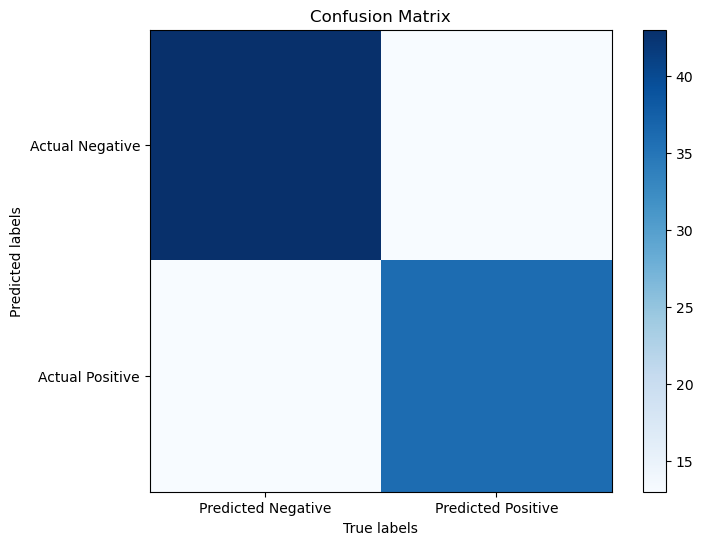

In [28]:
plot_conf_matrix(X_train, y_train, X_val, y_val, LogisticRegression, **lr_best_params)

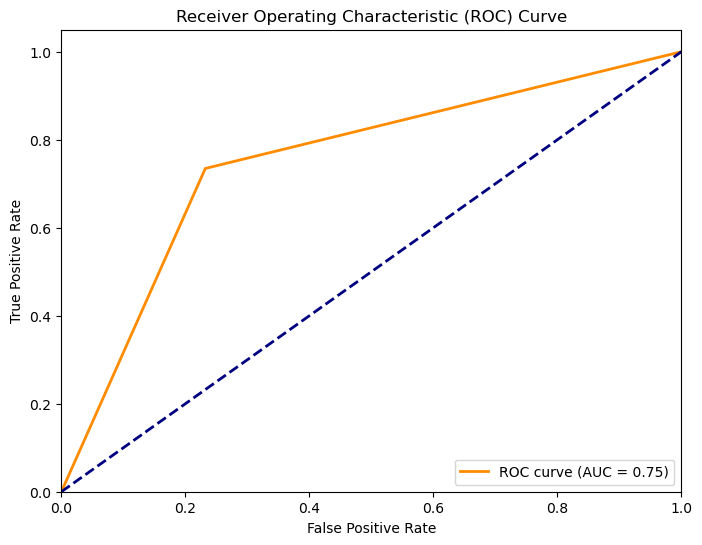

In [29]:
plot_roc_curve(X_train, y_train, X_val, y_val, LogisticRegression, **lr_best_params)

#### <a id="svc-analysis">SVC Model Analysis</a> <font size='2'>[Table of contents🔝](#index)<font size>

##### <a id="svc-tuning">Hyper Parameter Tuning</a> <font size='2'>[Table of contents🔝](#index)<font size>

In [30]:
def objective(trial):
   
    C = trial.suggest_float('C', 0.001, 1e5, log=True)
    kernel = trial.suggest_categorical('kernel', ['linear', 'rbf', 'sigmoid'])
    gamma = trial.suggest_float('gamma', 1e-5, 1e-3, log=True)
    degree = trial.suggest_int('degree', 0, 4) 
    
    model_kwargs = {'C': C, 'kernel': kernel, 'gamma': gamma, 'degree': degree}
    scores = train_model(X_train, y_train, X_val, y_val, SVC, **model_kwargs)

    return scores['recall']

In [31]:
from optuna.pruners import MedianPruner

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

[I 2024-01-23 21:04:23,122] A new study created in memory with name: no-name-10af7cef-9f16-4328-87f7-d6c3b3d7897c
[I 2024-01-23 21:04:23,153] Trial 0 finished with value: 0.0 and parameters: {'C': 6.880320929342662, 'kernel': 'rbf', 'gamma': 1.1260167151040576e-05, 'degree': 3}. Best is trial 0 with value: 0.0.
[I 2024-01-23 21:04:23,169] Trial 1 finished with value: 0.7346938775510204 and parameters: {'C': 0.028033264088393503, 'kernel': 'linear', 'gamma': 0.0001242369591946765, 'degree': 2}. Best is trial 1 with value: 0.7346938775510204.
[I 2024-01-23 21:04:23,193] Trial 2 finished with value: 0.0 and parameters: {'C': 0.00868176643393132, 'kernel': 'rbf', 'gamma': 7.689458024680697e-05, 'degree': 1}. Best is trial 1 with value: 0.7346938775510204.
[I 2024-01-23 21:04:23,218] Trial 3 finished with value: 0.0 and parameters: {'C': 0.04783282450474685, 'kernel': 'sigmoid', 'gamma': 1.6773635615824957e-05, 'degree': 1}. Best is trial 1 with value: 0.7346938775510204.
[I 2024-01-23 21:0

In [32]:
sv_best_params = study.best_params
sv_best_params

{'C': 0.028033264088393503,
 'kernel': 'linear',
 'gamma': 0.0001242369591946765,
 'degree': 2}

##### <a id="svc-evaluation">Model Evaluation</a> <font size='2'>[Table of contents🔝](#index)<font size>

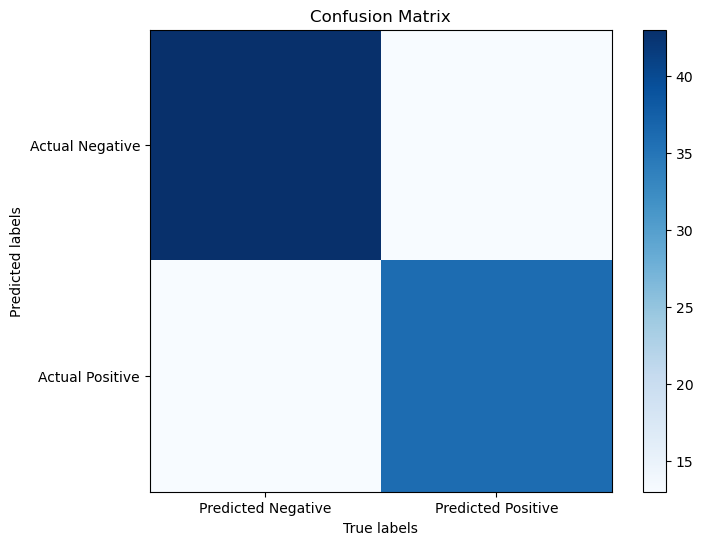

In [33]:
plot_conf_matrix(X_train, y_train, X_val, y_val, SVC, **sv_best_params)

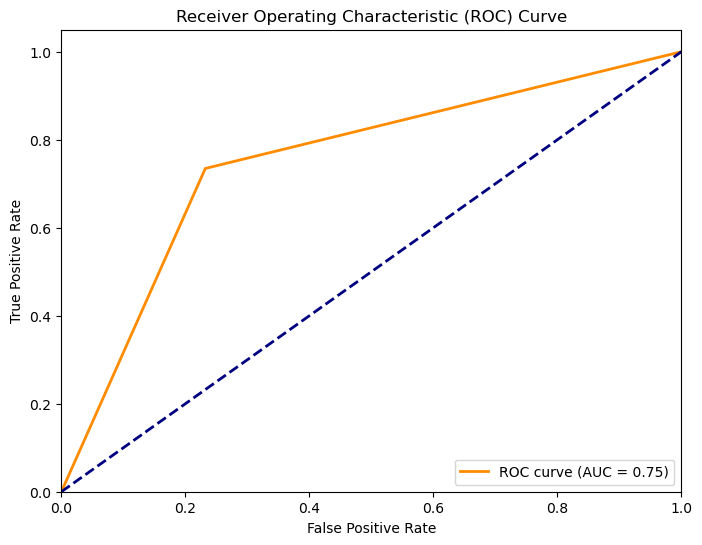

In [34]:
plot_roc_curve(X_train, y_train, X_val, y_val, SVC, **sv_best_params)

#### <a id="rfc-analysis">Ensemble Model: Random Forest Model Analysis</a> <font size='2'>[Table of contents🔝](#index)<font size>

##### <a id="rfc-tuning">Hyper Parameter Tuning</a> <font size='2'>[Table of contents🔝](#index)<font size>

In [35]:
def objective(trial):
    
    n_estimators = trial.suggest_int('n_estimators', 10, 1000)
    max_depth = trial.suggest_int('max_depth', 1, 32)
    min_samples_split = trial.suggest_float('min_samples_split', 0.001, 0.5, log=True)
    min_samples_leaf = trial.suggest_float('min_samples_leaf', 0.001, 0.5, log=True)
    max_features = trial.suggest_float('max_features', 0.1, 1.0)
    
    model_kwargs = {'n_estimators': n_estimators, 
                    'max_depth': max_depth, 
                    'min_samples_split': min_samples_split, 
                    'min_samples_leaf': min_samples_leaf, 
                    'max_features':max_features}
    scores = train_model(X_train, y_train, X_val, y_val, RandomForestClassifier, **model_kwargs)

    return scores['recall']

In [36]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2024-01-23 21:07:27,675] A new study created in memory with name: no-name-2f06cbfb-8158-415b-ae70-5b444e259147
[I 2024-01-23 21:07:28,375] Trial 0 finished with value: 0.32653061224489793 and parameters: {'n_estimators': 348, 'max_depth': 2, 'min_samples_split': 0.029699947233386655, 'min_samples_leaf': 0.04643310250884444, 'max_features': 0.3103347040547342}. Best is trial 0 with value: 0.32653061224489793.
[I 2024-01-23 21:07:29,989] Trial 1 finished with value: 0.3469387755102041 and parameters: {'n_estimators': 699, 'max_depth': 32, 'min_samples_split': 0.001121398941954157, 'min_samples_leaf': 0.08800168146652014, 'max_features': 0.38823588336830117}. Best is trial 1 with value: 0.3469387755102041.
[I 2024-01-23 21:07:32,196] Trial 2 finished with value: 0.7346938775510204 and parameters: {'n_estimators': 632, 'max_depth': 24, 'min_samples_split': 0.12425577181739882, 'min_samples_leaf': 0.00103182409403256, 'max_features': 0.6545277464139984}. Best is trial 2 with value: 0.734

In [37]:
rfc_best_params = study.best_params
rfc_best_params

{'n_estimators': 827,
 'max_depth': 21,
 'min_samples_split': 0.006574233395192783,
 'min_samples_leaf': 0.0010423001983436504,
 'max_features': 0.7286504395099895}

##### <a id="rfc-evaluation">Model Evaluation</a> <font size='2'>[Table of contents🔝](#index)<font size>

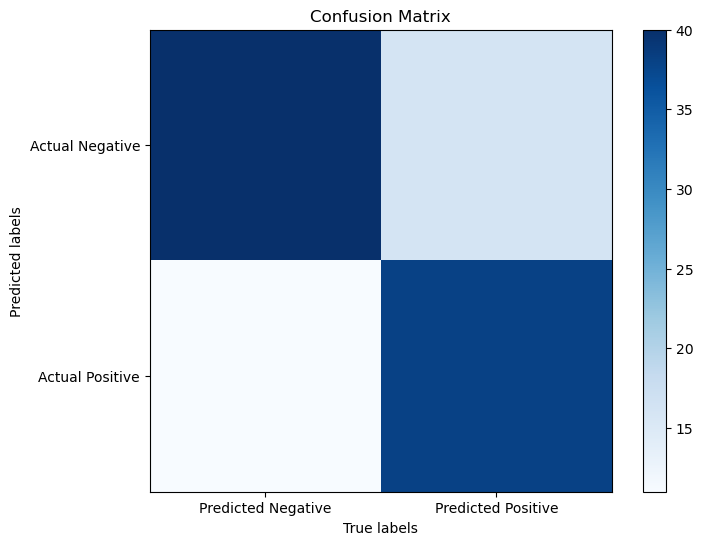

In [38]:
plot_conf_matrix(X_train, y_train, X_val, y_val, RandomForestClassifier, **rfc_best_params)

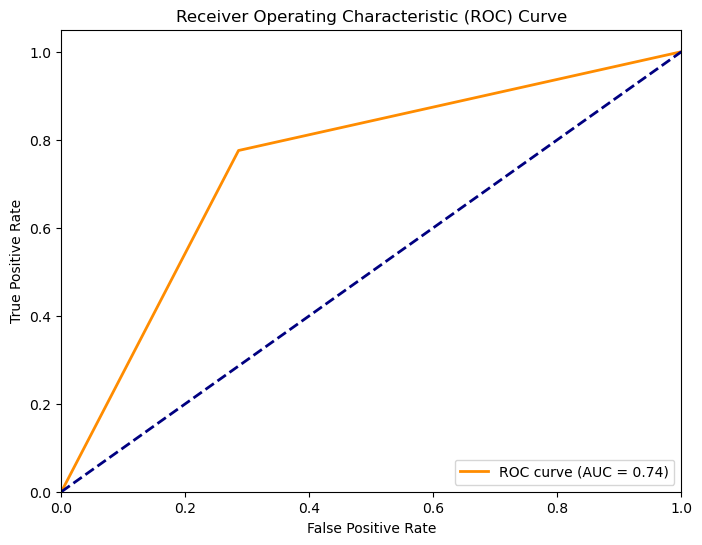

In [39]:
plot_roc_curve(X_train, y_train, X_val, y_val, RandomForestClassifier, **rfc_best_params)

### <a id="feature-importance">Feature Importance</a> <font size='2'>[Table of contents🔝](#index)<font size>

Let us determine what features had the modt impact in the predictions generated by our models. 
Random Forest Classifier has a great inbuilt method to determine feautre importance, we will take advantage of that fact.

In [40]:
rf_clf = get_trained_model(X_train, y_train, RandomForestClassifier, **rfc_best_params)
importances = rf_clf.named_steps['randomforestclassifier'].feature_importances_
importances

array([0.12854418, 0.09331558, 0.08365351, 0.00767877, 0.01390352,
       0.00646319, 0.00633235, 0.00810497, 0.01321334, 0.02386141,
       0.14647235, 0.13865485, 0.14266269, 0.14116653, 0.04597274])

In [41]:
rf_clf.named_steps

{'columntransformer': ColumnTransformer(remainder='passthrough',
                   transformers=[('onehotencoder',
                                  OneHotEncoder(handle_unknown='ignore'),
                                  ['category'])]),
 'standardscaler': StandardScaler(),
 'randomforestclassifier': RandomForestClassifier(max_depth=21, max_features=0.7286504395099895,
                        min_samples_leaf=0.0010423001983436504,
                        min_samples_split=0.006574233395192783, n_estimators=827,
                        random_state=124)}

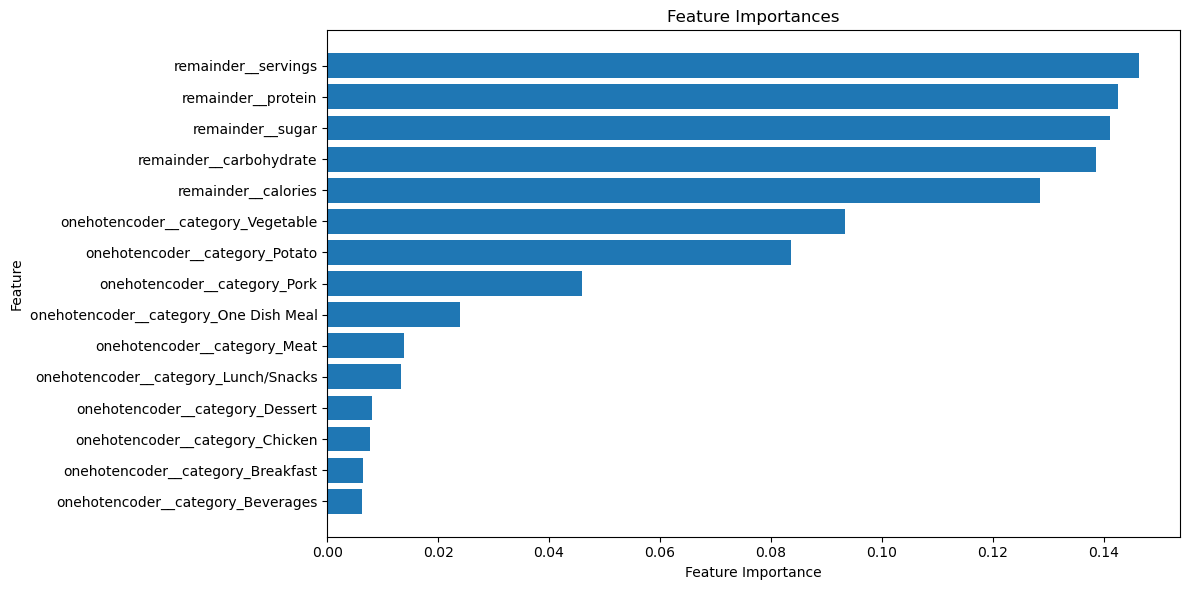

In [42]:
indices = importances.argsort()[::1]
feature_columns = rf_clf.named_steps['columntransformer'].get_feature_names_out().tolist()

plt.figure(figsize=(12, 6))
plt.title("Feature Importances")

plt.barh(range(len(indices)), importances[indices], align="center")
plt.yticks(range(len(indices)), feature_columns)
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

The most important features for predicting the popularithy of the recipe are the serving size followed by the recipe information measured in grams(protein, sugar, carbohydrate, and calories) and finaly the different categories seem to hold the least importance.

### <a id="target-optimization">Optimizing for the Target Class</a> <font size='2'>[Table of contents🔝](#index)<font size>

Optimizing for the Positively Predicted Class(i.e the high class, the recipes that generate high traffic)

In [43]:
rf_clf = get_trained_model(X_train, y_train, RandomForestClassifier, **rfc_best_params)
predicted_probabilities = rf_clf.predict_proba(X_val)[:, 1]

# Adjust the threshold to achieve the desired recall
desired_recall = 0.80  # Set your desired recall here
threshold_adjusted = np.percentile(predicted_probabilities, (1 - desired_recall) * 100)

# Use the adjusted threshold for predictions
predicted_labels = (predicted_probabilities > threshold_adjusted).astype(int)
predicted_labels

array([1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1])

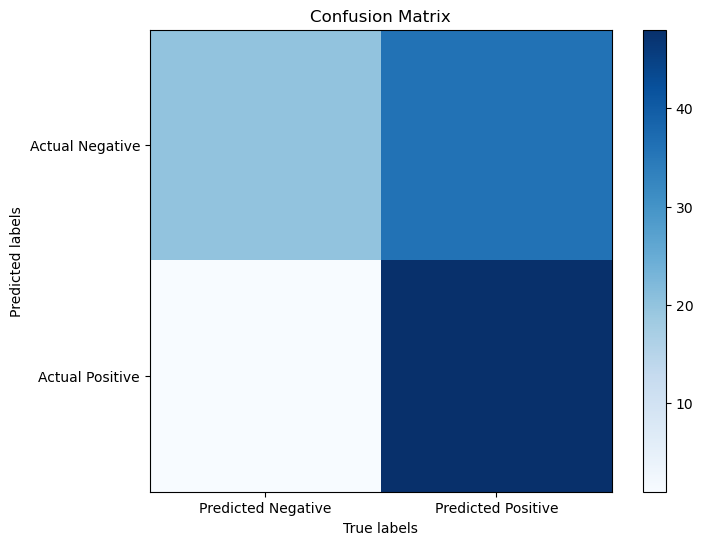

In [44]:
y_val_encoded  = encode_label(y_val)
conf_matrix = confusion_matrix(y_val_encoded, predicted_labels)
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks([0, 1], ['Predicted Negative', 'Predicted Positive'])
plt.yticks([0, 1], ['Actual Negative', 'Actual Positive'])
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

The approach to optimize for more high traffic predictions resulted in more miscalssifications.

## <a id="champion-model">Championing a Model</a> <font size='2'>[Table of contents🔝](#index)<font size>

All the models when hyper parameter tuned generate similar accuracy around 75% this might indicate that there is not enough pattern in the data to determine if a recipie would generate high traffic. We will champoin the Random Forest Classification model as the champoin model since it is an ensemble model, regulates overfitting and has a lower inference time due to the time it takes to train the model.

Next we retrain the champion model on the entire training set and validation set and evaluate it on unseen data(the test set).

In [45]:
merged_df = pd.concat([train_df,val_df], axis=0)
y_merged = merged_df['high_traffic']
X_merged = merged_df.drop('high_traffic', axis=1)

get_dataTypes_and_missingValues(merged_df)

,data_types,unique_values,missing_values
calories,float64,716,0
carbohydrate,float64,677,0
sugar,float64,568,0
protein,float64,628,0
category,object,10,0
servings,int32,4,0
high_traffic,object,2,0


Running the testing data through the pipeline

In [46]:
test_df = pd.concat([X_test, y_test], axis=1)
missing_indices = test_df[test_df['calories'].isnull()].index
test_df.drop(missing_indices, inplace=True)
get_dataTypes_and_missingValues(test_df)

,data_types,unique_values,missing_values
calories,float64,176,0
carbohydrate,float64,172,0
sugar,float64,163,0
protein,float64,170,0
category,object,11,0
servings,object,6,0
high_traffic,object,2,0


In [47]:
test_df['category'].replace('Chicken Breast', 'Chicken', inplace=True)
non_numeric_cols = test_df.drop('high_traffic', axis='columns').select_dtypes(exclude=np.number).columns.values
for col in non_numeric_cols:
    try:
        test_df[col] = test_df[col].astype(int)
    except Exception:
        print(f"The column: {col} contains non-numeric characters")

mask = test_df['servings'].astype(str).str.contains(r'\D', regex=True)
non_numeric_values = test_df[mask]

print("Non-numeric values in servings")
non_numeric_values

The column: category contains non-numeric characters
The column: servings contains non-numeric characters
Non-numeric values in servings


,calories,carbohydrate,sugar,protein,category,servings,high_traffic
548,1440.69,30.59,5.78,30.63,Lunch/Snacks,6 as a snack,High
451,1542.53,14.73,5.71,29.92,Lunch/Snacks,4 as a snack,High


In [48]:
test_df.at[548,'servings'] = 6
test_df.at[451,'servings'] = 4
test_df['servings'] = test_df['servings'].astype(int)

In [49]:
get_dataTypes_and_missingValues(val_df)

,data_types,unique_values,missing_values
calories,float64,105,0
carbohydrate,float64,104,0
sugar,float64,101,0
protein,float64,103,0
category,object,10,0
servings,int32,4,0
high_traffic,object,2,0


In [50]:
# split
y_test = test_df['high_traffic']
X_test = test_df.drop('high_traffic', axis=1)

Evaluating the champion model on unseen data

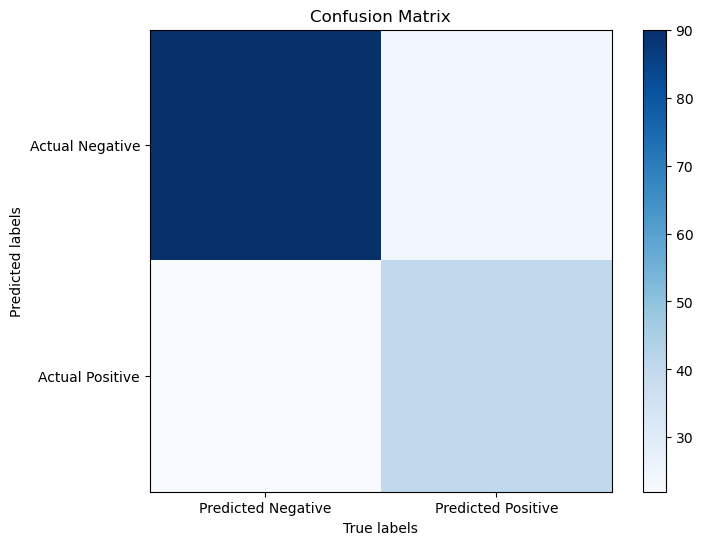

In [51]:
plot_conf_matrix(X_merged, y_merged, X_test, y_test, RandomForestClassifier, **rfc_best_params)

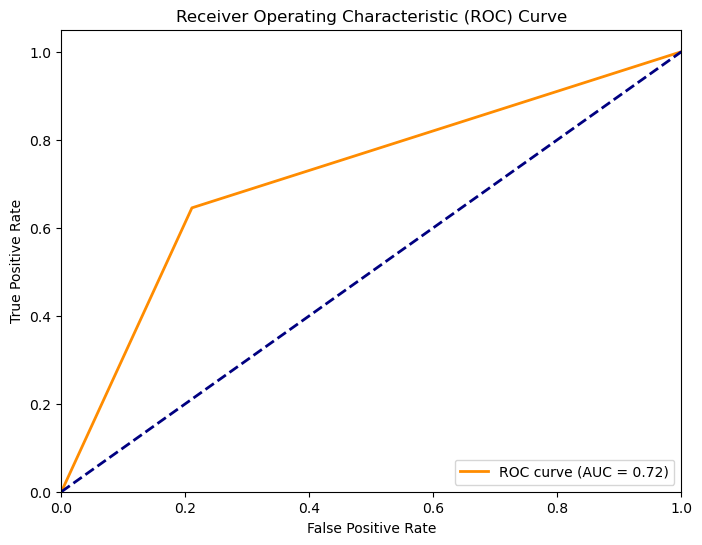

In [52]:
plot_roc_curve(X_merged, y_merged, X_test, y_test, RandomForestClassifier, **rfc_best_params)

In [53]:
train_model(X_merged, y_merged, X_test, y_test, RandomForestClassifier, **rfc_best_params)

,recall,f1_score
0,0.645161,0.634921


As expected the models performance metric drop a bit when evaluated on unseen data. There is a drop from ~75 to ~64.

## <a id="summary">Summary</a> <font size='2'>[Table of contents🔝](#index)<font size>

In this notebook we went through a couple of steps:
* Data collection
  * data imports
  * function definitions
* Preprocessing
  * data cleaning and validation following the steps in the data analysis notebook 
* Model Development
  * sample different model families
  * evaluate the models
  * hyper parameter tuning
  * determine feature importance
  * optimize for `high` traffic recipes
  * champion the optimal model and retrain it
  * evaluate champion model